In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

1. 读取数据集
2. 对训练集做可视化
3. 特征工程
4. 模型&预测
5. 模型融合

## 1.读取数据集

In [3]:
data_train = pd.read_csv('../../data/titanic/train.csv')
data_test = pd.read_csv('../../data/titanic/test.csv')
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2.对训练集做可视化

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


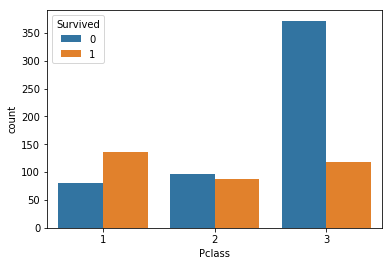

In [5]:
sns.countplot(data=data_train, x='Pclass', hue='Survived')

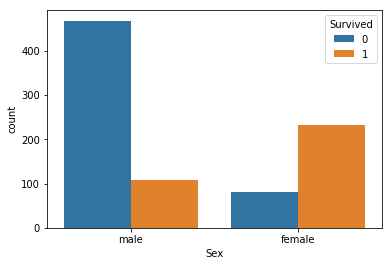

In [6]:
sns.countplot(data=data_train, x='Sex', hue='Survived')

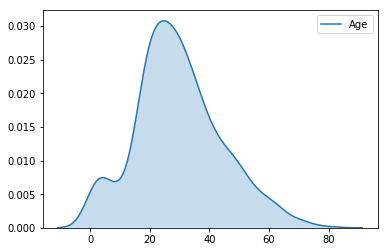

In [7]:
# 查看年龄分布
sns.kdeplot(data=data_train[data_train.Age.notnull()]['Age'],shade=True)

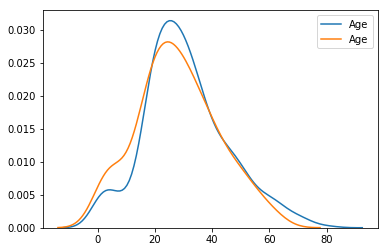

In [8]:
# 查看男女年龄分布
df_age_notnull = data_train[data_train['Age'].notnull()]
age_series_male = df_age_notnull[df_age_notnull['Sex'] == 'male']['Age']
age_series_female = df_age_notnull[df_age_notnull['Sex'] == 'female']['Age']
sns.kdeplot(data=age_series_male)
sns.kdeplot(data=age_series_female)

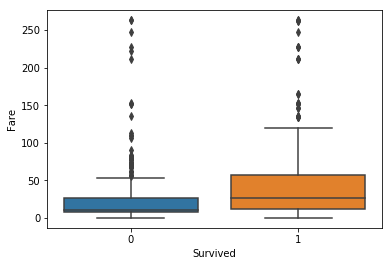

In [9]:
# 票价分布
sns.boxplot(data=data_train[data_train['Fare'] < 500], x='Survived', y='Fare')

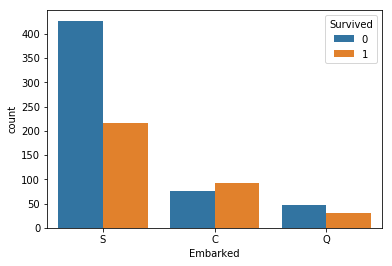

In [10]:
sns.countplot(data=data_train, x='Embarked', hue='Survived')

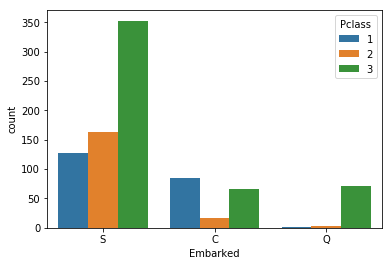

In [11]:
sns.countplot(data=data_train, x='Embarked', hue='Pclass')

## 3.特征工程

1. 合并训练集/测试集
2. 数据补全（均值/众数）
3. Pclass, Sex, Embarked onehot编码
4. 名字中提取称谓
5. 年龄离散化，创造新特征：小孩/老人
6. 票号中提取仓名
7. onehot处理称谓/离散化年龄/仓名
8. 分离训练集/测试集
9. 标准化Fare/Age

### 合并训练集/测试集

In [12]:
data_test['Survived'] = 0
# 这样写，是否data_train在前，data_test在后
data = pd.concat(objs=[data_train, data_test], axis=0)

### 数据补全
1. Embarked缺失很少，以众数填充
2. Fare缺失很少，以均值填充
3. Cabin数据缺失严重，直接删除
4. Age先以均值填充

In [13]:
data.loc[data['Embarked'].isnull(), 'Embarked'] = data.Embarked.value_counts(ascending=False)[0]

In [14]:
data.Embarked.value_counts()

S      914
C      270
Q      123
914      2
Name: Embarked, dtype: int64

In [15]:
data.loc[data['Fare'].isnull(), 'Fare'] = data.Fare.mean()

In [16]:
data.Fare.hasnans

False

In [17]:
data.drop(labels=['Cabin'], axis=1, inplace=True)

In [18]:
data.columns

Index(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass',
       'Sex', 'SibSp', 'Survived', 'Ticket'],
      dtype='object')

In [19]:
data.loc[data['Age'].isnull(), 'Age'] = data.Age.mean()

In [20]:
data.Age.hasnans

False

### Pclass, Sex, Embarked onehot编码

In [21]:
dummies = pd.get_dummies(data=data, columns=['Pclass', 'Sex', 'Embarked'])

In [22]:
dummies.head()

,Age,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_914,Embarked_C,Embarked_Q,Embarked_S
0,22.0,7.2500,"Braund, Mr. Owen Harris",0,1,1,0,A/5 21171,0,0,1,0,1,0,0,0,1
1,38.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,PC 17599,1,0,0,1,0,0,1,0,0
2,26.0,7.9250,"Heikkinen, Miss. Laina",0,3,0,1,STON/O2. 3101282,0,0,1,1,0,0,0,0,1
3,35.0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,113803,1,0,0,1,0,0,0,0,1
4,35.0,8.0500,"Allen, Mr. William Henry",0,5,0,0,373450,0,0,1,0,1,0,0,0,1


### Name中提取称谓

In [23]:
dummies['title'] = dummies.Name.str.extract('.+,(.+)\.',expand=False)

In [24]:
dummies = pd.get_dummies(data=dummies, columns=['title'])

### Age离散化，创造特征，老人/小孩

In [25]:
dummies['isChild'] = dummies.Age.apply(lambda a: 1 if a<= 15 else 0)

In [26]:
dummies['isOld'] = dummies.Age.apply(lambda a: 1 if a>= 50 else 0)

In [27]:
cuts = pd.cut(x=dummies.Age,bins=[0, 15, 25, 35, 40, 50, 100])

In [28]:
dummies_age = pd.get_dummies(cuts, prefix='age')

In [29]:
dummies = pd.concat(objs=[dummies, dummies_age], axis=1)

In [30]:
dummies.columns

Index(['Age', 'Fare', 'Name', 'Parch', 'PassengerId', 'SibSp', 'Survived',
       'Ticket', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Embarked_914', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'title_ Capt',
       'title_ Col', 'title_ Don', 'title_ Dona', 'title_ Dr',
       'title_ Jonkheer', 'title_ Lady', 'title_ Major', 'title_ Master',
       'title_ Miss', 'title_ Mlle', 'title_ Mme', 'title_ Mr', 'title_ Mrs',
       'title_ Mrs. Martin (Elizabeth L', 'title_ Ms', 'title_ Rev',
       'title_ Sir', 'title_ the Countess', 'isChild', 'isOld', 'age_(0, 15]',
       'age_(15, 25]', 'age_(25, 35]', 'age_(35, 40]', 'age_(40, 50]',
       'age_(50, 100]'],
      dtype='object')

### 票号中提取仓名

In [31]:
dummies['ticket_letter'] = dummies.Ticket.str.extract('^(.+)\s', expand=False)

In [32]:
dummies = pd.get_dummies(data=dummies, columns=['ticket_letter'], drop_first=True)

In [33]:
dummies.columns

Index(['Age', 'Fare', 'Name', 'Parch', 'PassengerId', 'SibSp', 'Survived',
       'Ticket', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Embarked_914', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'title_ Capt',
       'title_ Col', 'title_ Don', 'title_ Dona', 'title_ Dr',
       'title_ Jonkheer', 'title_ Lady', 'title_ Major', 'title_ Master',
       'title_ Miss', 'title_ Mlle', 'title_ Mme', 'title_ Mr', 'title_ Mrs',
       'title_ Mrs. Martin (Elizabeth L', 'title_ Ms', 'title_ Rev',
       'title_ Sir', 'title_ the Countess', 'isChild', 'isOld', 'age_(0, 15]',
       'age_(15, 25]', 'age_(25, 35]', 'age_(35, 40]', 'age_(40, 50]',
       'age_(50, 100]', 'ticket_letter_A./5.', 'ticket_letter_A.5.',
       'ticket_letter_A/4', 'ticket_letter_A/4.', 'ticket_letter_A/5',
       'ticket_letter_A/5.', 'ticket_letter_A/S', 'ticket_letter_A4.',
       'ticket_letter_AQ/3.', 'ticket_letter_AQ/4', 'ticket_letter_C',
       'ticket_letter_C.A.', 'ticket_letter_C.A./S

In [34]:
dummies.drop(labels=['Age', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [35]:
dummies.columns

Index(['Fare', 'Parch', 'SibSp', 'Survived', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_914', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'title_ Capt', 'title_ Col', 'title_ Don',
       'title_ Dona', 'title_ Dr', 'title_ Jonkheer', 'title_ Lady',
       'title_ Major', 'title_ Master', 'title_ Miss', 'title_ Mlle',
       'title_ Mme', 'title_ Mr', 'title_ Mrs',
       'title_ Mrs. Martin (Elizabeth L', 'title_ Ms', 'title_ Rev',
       'title_ Sir', 'title_ the Countess', 'isChild', 'isOld', 'age_(0, 15]',
       'age_(15, 25]', 'age_(25, 35]', 'age_(35, 40]', 'age_(40, 50]',
       'age_(50, 100]', 'ticket_letter_A./5.', 'ticket_letter_A.5.',
       'ticket_letter_A/4', 'ticket_letter_A/4.', 'ticket_letter_A/5',
       'ticket_letter_A/5.', 'ticket_letter_A/S', 'ticket_letter_A4.',
       'ticket_letter_AQ/3.', 'ticket_letter_AQ/4', 'ticket_letter_C',
       'ticket_letter_C.A.', 'ticket_letter_C.A./SOTON', 'ticket_letter_CA',
       'ticke

### 分离训练集/测试集

In [36]:
X_train = dummies[:data_train.shape[0]]
X_test = dummies[data_train.shape[0]:]

In [37]:
y_train = X_train.Survived
X_train = X_train.drop(axis=1, labels=['Survived'])
X_test = X_test.drop(axis=1, labels=['Survived'])

In [38]:
X_train.head()

,Fare,Parch,SibSp,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_914,Embarked_C,...,ticket_letter_SOTON/O2,ticket_letter_SOTON/OQ,ticket_letter_STON/O 2.,ticket_letter_STON/O2.,ticket_letter_STON/OQ.,ticket_letter_SW/PP,ticket_letter_W./C.,ticket_letter_W.E.P.,ticket_letter_W/C,ticket_letter_WE/P
0,7.2500,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,71.2833,0,1,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,7.9250,0,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,53.1000,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.0500,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Fare标准化

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
scaler = StandardScaler()

In [41]:
X_train = scaler.fit_transform(X=X_train)
X_test = scaler.transform(X=X_test)

## 模型/预测

### 随机森林

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
rf = RandomForestClassifier(n_estimators=150, max_depth=6, min_samples_leaf=2, oob_score=True)

In [44]:
rf.fit(X_train, y_train)
print('oob_score:', rf.oob_score_)

oob_score: 0.824915824916


In [45]:
data_test['Survived'] = rf.predict(X_test)

In [46]:
res = data_test[['PassengerId', 'Survived']].set_index('PassengerId')

In [47]:
res.to_csv('rf.csv')

### 逻辑回归

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV

/Users/lpf599/anaconda3/envs/ml_py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/lpf599/anaconda3/envs/ml_py36/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [49]:
param = {'C': np.linspace(start=0.0001, stop=10, num=6), 'max_iter':[150, 200]}

In [50]:
lr = LogisticRegression()
clf = GridSearchCV(estimator=lr, param_grid=param, cv=5, n_jobs=-1, scoring='roc_auc')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-04,   2.00008e+00,   4.00006e+00,   6.00004e+00,
         8.00002e+00,   1.00000e+01]), 'max_iter': [150, 200]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [51]:
lr = LogisticRegression(**clf.best_params_)
lr.fit(X_train, y_train)
print('score:', lr.score(X_train, y_train))
data_test['Survived'] = lr.predict(X_test)

score: 0.838383838384


In [52]:
res = data_test[['PassengerId', 'Survived']].set_index('PassengerId')

In [53]:
res.to_csv('lr.csv')

### SVM

In [54]:
svc = sklearn.svm.SVC()

In [55]:
param = {'C': np.logspace(-3,2, 6), 'max_iter': [2000, 8000]}

In [56]:
clf = GridSearchCV(estimator=svc, param_grid=param, cv=5, n_jobs=-1, verbose=1, scoring='roc_auc')
clf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/lpf599/anaconda3/envs/ml_py36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/lpf599/anaconda3/envs/ml_py36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/lpf599/anaconda3/envs/ml_py36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/lpf599/anaconda3/envs/ml_py36/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMa

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02]), 'max_iter': [2000, 8000]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

In [57]:
data_test['Survived'] = clf.best_estimator_.predict(X_test)

In [58]:
res = data_test[['PassengerId', 'Survived']].set_index('PassengerId')
res.to_csv('svm.csv')

### xgboost

In [61]:
import xgboost as xgb

In [62]:
clf = xgb.XGBClassifier(max_depth=6, n_estimators=150, num_round=5)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, num_round=5, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [63]:
data_test['Survived'] = clf.predict(X_test)
res = data_test[['PassengerId', 'Survived']].set_index('PassengerId')
res.to_csv('xgb.csv')

### gbdt

In [64]:
gbdt = sklearn.ensemble.GradientBoostingClassifier(learning_rate=0.7, max_depth=6, n_estimators=150, min_samples_leaf=2)

In [65]:
gbdt.fit(X_train, y_train)
data_test['Survived'] = gbdt.predict(X_test)
res = data_test[['PassengerId', 'Survived']].set_index('PassengerId')
res.to_csv('gbdt.csv')

## 模型融合

### voting